<a href="https://colab.research.google.com/github/AngelaRemolina/NLP-Notebooks/blob/main/06_Sequence_Labelling_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Labelling and Classification

In this session we will train a Text classifier that makes use of a Bidirectional LSTM (Long Short-term Memory) model.

In the second part of the tutorial we will first investigate Part-of-Speech (POS) tagging and Named-entity recognition (NER).
- For this we will make use of the spaCy natural langauge processing API: https://spacy.io/
- spaCy is an opensource API that provides state-of-the-art performance on sequence labeling tasks such as POS tagging and NER.
- Parts of this tutorial are based on code from: https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da


**Optional for Colab users**

Before starting, we can set up the connection with the Google Dive storage, to keep there our documents.
Just execute the following passages:

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make sure that the variable path contains the correct sequence of folders separate by a `'/'` to get to your lecture files

In [19]:
import os

path = 'Colab Notebooks/NLP/Practical_06'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/NLP/Practical_06'

## Sequence labelling with embeddings and a Recurrent Neural Network

In this section of the notebook I will run through an example of using LSTM (Long Short-term Memory) network for text sequence labelling.
We can train our own model for POS-tagging or NER.
Moreover, we can use pre-trained embedding models to encode the input text.

- We are going to use PyTorch (https://pytorch.org) to build and train our model. Pytorch is a state-of-the-art framework for deep leaning.

### Data preparation

As usula we start from data preparation.
We can use the [CoNLL 2003](https://www.clips.uantwerpen.be/conll2003/ner/) corpus, which provides corpora for POS-tagging, Chunking and NER in English and German.
Today we are going to focus on NER in English.

You can find a copy the English split in the `docs/` directory.
Usually the corpus should require preprocessing the data, here I am providing you with a version from Kaggle where documents have already been tagged (source: https://www.kaggle.com/datasets/alaakhaled/conll003-englishversion?resource=download)

Let's start by loading the three files (train/validation/test) in memory and reading all of them.

In [20]:
raw_data = dict()

for split in ['train', 'valid', 'test']:
    with open(f'docs/CoNLL - 2003/{split}.txt') as f:
        raw_data[split] = f.read().strip()

print(raw_data['train'][:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP


Now we can parse the data.
Documents inside each split are separated by the sequence `-DOCSTART- -X- -X- O`.
Sentences inside each document are separated by the sequence`\n\n` (two new-line characters).
Each line inside a sentence represnets a token followed by the POS tag, the CHUNK tag and the NER tag, all separaated by spaces.

Here NER tags are written using a system called BIO-tagging.
The 'B' stands for "begin" and introduces (starts) a new named entity, the tags are written as "B-PER" to indicate a person or "B-LOC" to indicate a location and so on.
The 'I' stands for "inside" and continues a started named entity, the tags are written as "I-PER" to indicate a person or "I-LOC" to indicate a location and so on.
The 'O' stands for outside, it means that the token is outside any named entity.
There are other tagging systems.  

In [21]:
keys = ['text', 'pos_tag', 'chunk_tag', 'ner_tag']

data = dict()

for split in raw_data:
    data[split] = list()
    for doc in raw_data[split].split('-DOCSTART- -X- -X- O')[1:]:
        for sentence in doc.strip().split('\n\n'):
            data[split].append(list())
            for elem in sentence.split('\n'):
                data[split][-1].append(dict(zip(keys, elem.split())))

In [22]:
data['train'][0]

[{'text': 'EU', 'pos_tag': 'NNP', 'chunk_tag': 'B-NP', 'ner_tag': 'B-ORG'},
 {'text': 'rejects', 'pos_tag': 'VBZ', 'chunk_tag': 'B-VP', 'ner_tag': 'O'},
 {'text': 'German', 'pos_tag': 'JJ', 'chunk_tag': 'B-NP', 'ner_tag': 'B-MISC'},
 {'text': 'call', 'pos_tag': 'NN', 'chunk_tag': 'I-NP', 'ner_tag': 'O'},
 {'text': 'to', 'pos_tag': 'TO', 'chunk_tag': 'B-VP', 'ner_tag': 'O'},
 {'text': 'boycott', 'pos_tag': 'VB', 'chunk_tag': 'I-VP', 'ner_tag': 'O'},
 {'text': 'British',
  'pos_tag': 'JJ',
  'chunk_tag': 'B-NP',
  'ner_tag': 'B-MISC'},
 {'text': 'lamb', 'pos_tag': 'NN', 'chunk_tag': 'I-NP', 'ner_tag': 'O'},
 {'text': '.', 'pos_tag': '.', 'chunk_tag': 'O', 'ner_tag': 'O'}]

Now all the labels are properly organised

At this point we need a system ti encode and decode the labels into categorical entities.
We can use the label encoder from Scikit-Learn for that (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [23]:
from sklearn.preprocessing import LabelEncoder

pos_le = LabelEncoder().fit([token['pos_tag'] for split in data.values() for sentence in split for token in sentence])
chunk_le = LabelEncoder().fit([token['chunk_tag'] for split in data.values() for sentence in split for token in sentence])
ner_le = LabelEncoder().fit([token['ner_tag'] for split in data.values() for sentence in split for token in sentence])

Now we have a module mapping from tags to IDs and vice-versa

In [32]:
ner_tag = ['I-PER']
ner_tag = ['I-LOC']
ner_tag = ['B-PER']
ner_tag = ['O']

ner_le.transform(ner_tag)

array([8])

In [33]:
ner_tag_id = [8]

ner_le.inverse_transform(ner_tag_id)

array(['O'], dtype='<U6')

How many NER tags do we have?

In [34]:
len(ner_le.classes_)

9

Which are those tags?

In [35]:
ner_le.classes_

array(['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG',
       'I-PER', 'O'], dtype='<U6')

Collect the same info for POS tags

In [36]:
pos_le.classes_

array(['"', '$', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX',
       'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS',
       'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS',
       'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
       'WDT', 'WP', 'WP$', 'WRB'], dtype='<U6')

In [37]:
chunk_le.classes_

array(['B-ADJP', 'B-ADVP', 'B-CONJP', 'B-INTJ', 'B-LST', 'B-NP', 'B-PP',
       'B-PRT', 'B-SBAR', 'B-VP', 'I-ADJP', 'I-ADVP', 'I-CONJP', 'I-INTJ',
       'I-LST', 'I-NP', 'I-PP', 'I-PRT', 'I-SBAR', 'I-VP', 'O'],
      dtype='<U7')

Finally we separate our train-validation-test splits

In [38]:
train_data, valid_data, test_data = data.values()

### Defining and training the RNN model for NER

We start by installing PyTorch and importing the required modules

In [15]:
!pip install torch gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.8 MB/s eta 0:00:00


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

The we load the Word Embedding model we want to use. We can re-use the 50 dimensional GloVe emebddings from last time

In [40]:
import gensim.downloader as api

we_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


Before creating the LSTM we decide where to train our model, either cpu or gpu, depending on which is avaialble.

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Now we can create our RNN module.
Here are the available modules for PyTorch: https://pytorch.org/docs/stable/nn.html#recurrent-layers

We define a custom LSTM using PyTorch API.
In our model we stack one or more LSTM layers (we can make it variable) and we put a linear layer (a.k.a. dense layer or fully connected layer on top of it).

When you define a neural network in PyTorch you need it to extend the `torch.nn.Module` class and implement the forward method (the one that computes the output).

In [42]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_lstm=1):
        super().__init__()
        # List of LSTM layers
        self.lstm = nn.ModuleList([
            nn.LSTM(
                input_size=input_size if i == 0 else hidden_size,
                hidden_size=hidden_size,
                batch_first=True,
                bidirectional=True,
                dropout=0.2
            )
            for i in range(n_lstm)
        ])
        # Lat linear projection
        self.cls_head = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Run though all the LSTM layers
        for lstm_layer in self.lstm:
            # Compute new hidden representation
            x, _ = lstm_layer(x)
            # Average the hidden output from the two directions of the LSTM
            x = (x[..., :x.size(-1) // 2] + x[..., x.size(-1) // 2:]) / 2
        # Apply last lineat projection
        y = self.cls_head(x)

        return y

Let's create an instance of our LSTM

In [43]:
lstm = CustomLSTM(300, 300, len(ner_le.classes_), n_lstm=3)
lstm

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


CustomLSTM(
  (lstm): ModuleList(
    (0-2): 3 x LSTM(300, 300, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (cls_head): Linear(in_features=300, out_features=9, bias=True)
)

Now we can move the LSTM to the target device

In [44]:
lstm = lstm.to(device)

Once we have the model we need to create an optimizer that will take care of updating the weights. Here are the available optimizers: https://pytorch.org/docs/stable/optim.html.
I'm going to use RMSProp.

The optimizer needs to receive the parameters of the neural network and the selected learning rate

In [45]:
lr = 0.0005
optimizer = torch.optim.RMSprop(params=lstm.parameters(), lr=lr)

Now we need to prepare our data.
Before doing so we prepare a function that maps a mini-batch of samples (i.e., a subset of the lists of dictionaries we prepared) to input tensors to use with our model. The function willl take care of:
- Mapping all words to their embeddings with size $d$
- Collect the emebddings of the same sentence into a matrix with shape $(n_\textit{words in sentence}, d)$
- Collect the different matrices of the same batch into a single tensor with shape $(n_\textit{batch elements}, n_\textit{words in longest sentence}, d)$ (this will be input).
- Mapping all the labels to their IDs
- Collecting all the IDs of the same sentence into a vector with size $n_\textit{words in sentence}$
- Collecting all the different vectors into a matrix with shape $(n_\textit{batch elements}, n_\textit{words in longest sentence})$ (this will be target output).

Note that different sentences have different lengths, to cope with this issue we apply a process called padding: we are going to add to the input tensor and the target output matrix  dummy values to have all the same "sentence length".

In [46]:
import numpy as np

def collate(mini_batch):
    # Get the length of the longest sentence
    longest_len = max(len(sample) for sample in mini_batch)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((len(mini_batch), longest_len, 300))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_lbl = np.full((len(mini_batch), longest_len), -100)
    # Fill the tensor and the matrix
    for i, sample in enumerate(mini_batch):
        for j, token in enumerate(sample):
            # Manage missing tokens in vocabulary
            if token['text'].lower() in we_model:
                input_embeds[i,j] = we_model[token['text'].lower()]
            output_lbl[i,j] = ner_le.transform([token['ner_tag']])[0]
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float)
    output_lbl = torch.tensor(output_lbl)

    return input_embeds, output_lbl

How does an encoded batch looks like? Let's enode the first three sentences

In [47]:
train_data[:3]

[[{'text': 'EU', 'pos_tag': 'NNP', 'chunk_tag': 'B-NP', 'ner_tag': 'B-ORG'},
  {'text': 'rejects', 'pos_tag': 'VBZ', 'chunk_tag': 'B-VP', 'ner_tag': 'O'},
  {'text': 'German',
   'pos_tag': 'JJ',
   'chunk_tag': 'B-NP',
   'ner_tag': 'B-MISC'},
  {'text': 'call', 'pos_tag': 'NN', 'chunk_tag': 'I-NP', 'ner_tag': 'O'},
  {'text': 'to', 'pos_tag': 'TO', 'chunk_tag': 'B-VP', 'ner_tag': 'O'},
  {'text': 'boycott', 'pos_tag': 'VB', 'chunk_tag': 'I-VP', 'ner_tag': 'O'},
  {'text': 'British',
   'pos_tag': 'JJ',
   'chunk_tag': 'B-NP',
   'ner_tag': 'B-MISC'},
  {'text': 'lamb', 'pos_tag': 'NN', 'chunk_tag': 'I-NP', 'ner_tag': 'O'},
  {'text': '.', 'pos_tag': '.', 'chunk_tag': 'O', 'ner_tag': 'O'}],
 [{'text': 'Peter', 'pos_tag': 'NNP', 'chunk_tag': 'B-NP', 'ner_tag': 'B-PER'},
  {'text': 'Blackburn',
   'pos_tag': 'NNP',
   'chunk_tag': 'I-NP',
   'ner_tag': 'I-PER'}],
 [{'text': 'BRUSSELS',
   'pos_tag': 'NNP',
   'chunk_tag': 'B-NP',
   'ner_tag': 'B-LOC'},
  {'text': '1996-08-22',
   'pos_

In [48]:
embeds, lbl = collate(train_data[:3])

print(f"The shape of the input is: {embeds.size()}") # 9 = lenght of the longest sequence
print(f"The shape of the output is: {lbl.size()}")

The shape of the input is: torch.Size([3, 9, 300])
The shape of the output is: torch.Size([3, 9])


In [49]:
embeds

tensor([[[ 0.5473, -0.2364, -0.2143,  ..., -0.3137, -0.4393,  0.1852],
         [ 0.4056, -0.0393, -0.2357,  ..., -0.2026,  0.1970,  0.4861],
         [-0.1740,  0.2612, -0.5919,  ..., -0.1950,  0.2041,  0.3530],
         ...,
         [ 0.4436, -0.2418,  0.2366,  ...,  0.1857, -0.2956, -0.1999],
         [ 0.1964, -0.2666,  0.1819,  ...,  0.1678,  0.0395,  0.4751],
         [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368]],

        [[ 0.1093, -0.1402,  0.0930,  ...,  0.3865,  0.3444,  0.0214],
         [-0.4132,  0.2175, -0.0505,  ..., -0.4873, -0.4033, -0.3469],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.4693, -0.0993,  0.0016,  ..., -0.4687, -0.7363,  0.1922],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [50]:
lbl

tensor([[   2,    8,    1,    8,    8,    8,    1,    8,    8],
        [   3,    7, -100, -100, -100, -100, -100, -100, -100],
        [   0,    8, -100, -100, -100, -100, -100, -100, -100]])

Now we can finally wrap a DataLoader around our samples. PyTorch data loaders take care of generating batches on a given data set. We just need to set the batch size.

In [51]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=collate, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

We can train the lst iterating over the data set for a given number of epochs

In [52]:
# Import nice loading bar using tqdm
from tqdm import tqdm

# Set model in training mode
lstm.train()

# Accumulator of loss
history = []

n_epochs = 10

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    for embeds, lbl in tqdm(train_loader):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Move input and output to target device
        embeds = embeds.to(device)
        lbl = lbl.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = lstm(embeds)
        # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
        logits = logits.reshape(-1, len(ner_le.classes_))
        # Flatten targets to a shape (batch_size * max_sentence_len)
        lbl = lbl.reshape(-1)
        # Compute loss
        loss = F.cross_entropy(logits, lbl)
        # Compute gradients
        loss.backward()
        # Update weights
        optimizer.step()
        # Save loss
        history.append(loss.detach())

history = [loss.cpu().item() for loss in history]

Starting epoch 1/10


100%|██████████| 110/110 [00:16<00:00,  6.85it/s]


Starting epoch 2/10


100%|██████████| 110/110 [00:15<00:00,  6.91it/s]


Starting epoch 3/10


100%|██████████| 110/110 [00:16<00:00,  6.83it/s]


Starting epoch 4/10


100%|██████████| 110/110 [00:16<00:00,  6.83it/s]


Starting epoch 5/10


100%|██████████| 110/110 [00:16<00:00,  6.79it/s]


Starting epoch 6/10


100%|██████████| 110/110 [00:16<00:00,  6.74it/s]


Starting epoch 7/10


100%|██████████| 110/110 [00:15<00:00,  6.91it/s]


Starting epoch 8/10


100%|██████████| 110/110 [00:16<00:00,  6.80it/s]


Starting epoch 9/10


100%|██████████| 110/110 [00:16<00:00,  6.64it/s]


Starting epoch 10/10


100%|██████████| 110/110 [00:16<00:00,  6.57it/s]


Now we can plot the evolution of the loss at each update

Text(0, 0.5, 'Loss')

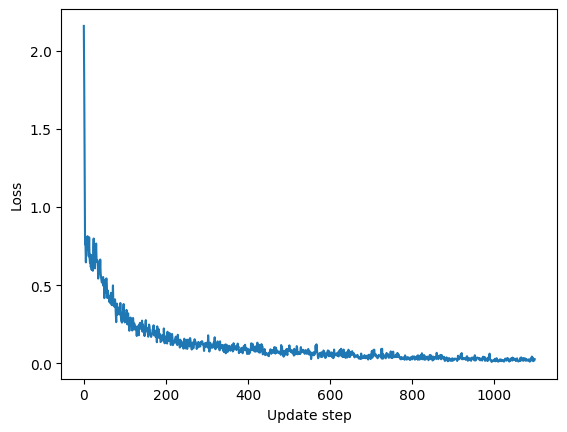

In [53]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(range(len(history)), history)
plt.xlabel('Update step')
plt.ylabel('Loss')

We can also test out model using the dedicated split. We iterate over the mini batches, colelct the prediction as the value with the highest logit value and we store these values until we go through the entire data set. Then we compute the classification report

In [54]:
from sklearn.metrics import classification_report

# Set model in evaluation mode
lstm.eval()

# Accumulators for target labels and predictions
y_true = []
y_pred = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, lbl in tqdm(valid_loader):
        # Move input and output to target device
        embeds = embeds.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = lstm(embeds)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted labels
        y_pred.append(pred_lbl.reshape(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.reshape(-1).numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]

# Finally compute classification report
print(classification_report(y_true, y_pred, target_names=ner_le.classes_))

100%|██████████| 26/26 [00:04<00:00,  5.84it/s]

              precision    recall  f1-score   support

       B-LOC       0.95      0.91      0.93      1837
      B-MISC       0.89      0.80      0.84       922
       B-ORG       0.82      0.86      0.84      1341
       B-PER       0.93      0.97      0.95      1842
       I-LOC       0.86      0.82      0.84       257
      I-MISC       0.83      0.62      0.71       346
       I-ORG       0.81      0.78      0.79       751
       I-PER       0.97      0.96      0.96      1307
           O       0.99      0.99      0.99     42759

    accuracy                           0.97     51362
   macro avg       0.89      0.86      0.87     51362
weighted avg       0.97      0.97      0.97     51362



What do we see from these results?

We can play a bit with the model directly.

Let's define a function to compute the predictions give a sentence. We will use the NLTK tokenizer to split the sentence into word tokens

In [55]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

def predict(sample):
    # Tokenize sample
    tokenized_sample = word_tokenize(sample)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((1, len(tokenized_sample), 300))
    # Fill the tensor and the matrix
    for i, token in enumerate(tokenized_sample):
        # Manage missing tokens in vocabulary
        if token.lower() in we_model:
            input_embeds[0, i] = we_model[token.lower()]
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float, device=device)
    # Run model over input
    logits = lstm(embeds)
    # Get predictions as the index corresponding to the highest logit score
    pred_lbl = torch.argmax(logits, dim=-1)
    # Decode labels
    pred_labels = ner_le.inverse_transform(pred_lbl.reshape(-1).cpu().numpy())
    # Group together tokens and predicted NER labels
    labelled_sample = [{'text': token, 'ner_tag': str(lbl)} for token, lbl in zip(tokenized_sample, pred_labels)]

    return labelled_sample

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


And now call it on a custom sample

In [56]:
sample = "Hello, my name is Vincenzo Scotti, I am from Italy and I like pizza."

predict(sample)

[{'text': 'Hello', 'ner_tag': 'O'},
 {'text': ',', 'ner_tag': 'O'},
 {'text': 'my', 'ner_tag': 'O'},
 {'text': 'name', 'ner_tag': 'O'},
 {'text': 'is', 'ner_tag': 'O'},
 {'text': 'Vincenzo', 'ner_tag': 'B-LOC'},
 {'text': 'Scotti', 'ner_tag': 'O'},
 {'text': ',', 'ner_tag': 'O'},
 {'text': 'I', 'ner_tag': 'O'},
 {'text': 'am', 'ner_tag': 'O'},
 {'text': 'from', 'ner_tag': 'O'},
 {'text': 'Italy', 'ner_tag': 'O'},
 {'text': 'and', 'ner_tag': 'O'},
 {'text': 'I', 'ner_tag': 'O'},
 {'text': 'like', 'ner_tag': 'O'},
 {'text': 'pizza', 'ner_tag': 'O'},
 {'text': '.', 'ner_tag': 'O'}]

Look how our custom model fails flawlessly

### Defining and training the RNN model for POS-tagging or Chunking

You can do this at home to start getting familiar with PyTorch and RNNs

In [ ]:
# TODO

## Text Classification with a Recurrent Neural Network

In this last section of the notebook I will run through a quick example of using a Bidirectional LSTM (Long Short-term Memory) network for text classification.
- RNNs extend embedding-based classification of text by taking word-order into account. They were, until relatively recently, the state-of-the-art when it came to training text classifiers.
- Tensorflow is sophisticated toolkit for building Deep Neural Network models. We will use it to build the model. The tutorial follows mostly this Tensorflow tutorial: https://www.tensorflow.org/tutorials/text/text_classification_rnn
    - Tensorflow is to deep learning learning what Java is to programming (joking...?)


### Data preparation

First let's load the Twitter dataset we used in the second session:

In [ ]:
import nltk
nltk.download('twitter_samples')

from nltk.corpus import twitter_samples
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

Remove emoticons from the positive and negative examples:

In [ ]:
import re
emoticon_regex = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'
positive_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in positive_tweets]
negative_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in negative_tweets]

And create the examples and labels as we did before. This time we will use numeric labels (0,1) instead of text labels ('negative','positive'), since the deep learning library we will use requires numeric class labels.

In [ ]:
tweets_x = positive_tweets_noemoticons + negative_tweets_noemoticons
tweets_y = [1]*len(positive_tweets) + [0]*len(negative_tweets)

And again, split the data into training, validation and test:

In [ ]:
from sklearn.model_selection import train_test_split
temp_x, test_x, temp_y, test_y = train_test_split(tweets_x, tweets_y, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

Now that we have the training and validation data prepared, we can import the Tensorflow library, and use it to load the training and validaton datasets into the tensorflow format. Note that:
- Tensorflow comes installed on Google Colab.
- If you run this notebook on your own machine you will need to first install tensorflow using '!pip install'

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

train_tf = tf.data.Dataset.from_tensor_slices((train_x, train_y))
valid_tf = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

Training will run on *batches* of the data at a time, so we need to create them.
- We first use the shuffle command to randomise the order of the training data. (The buffer-size limits the number of instances loaded into memory when shuffling and is only for efficiency -- you could remove it.)
- We then create the batches. Each batch will contain 64 examples.
- The validation data needs to have the same format as the training data, so we batch it too.

In [ ]:
train_dataset = train_tf.shuffle(buffer_size=10000).batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

Let's have a look at the first batch in the training data. It consists of:
- an array of strings (tweets)
- an array of binary values (class labels)

In [ ]:
for batch in train_dataset.take(1):
  print(batch)

Now that we have the text data in the format required, we can vectorize it. We will need to make use a specific text vectorization module from tensorflow to do this.
- We first limit the vocabulary of the vectorizer to 5000,
- then extract only the text portion of the training dataset,
- and finally fit the vectorizer to the text using the 'adapt' method:

In [ ]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=5000)
train_text = train_dataset.map(lambda text, label: text)
vectorizer.adapt(train_text)

Let's print out the first tokens form the vocabulary:

In [ ]:
vocab = vectorizer.get_vocabulary()
vocab[:100]

Note that the first two tokens in the vocabulary are the empty token '', and the unknown token '[UNK]'. The latter is used to mask out-of-vocabulary tokens in the text

We can now use the vectorizer to encode a tweet:

In [ ]:
text = 'This is my first tweet! It contains one out-of-vocabulary term. Any suggestions for extending this tweet?'
encoding = vectorizer([text]).numpy()[0]
print('Tweet:     ', text)
print('Encoded:   ', encoding)
print('Recovered: ',' '.join([vocab[i] for i in encoding]))

Note that the vectorizer is not turning the text into a single vector, but is simply replacing the vocabulary words by their indices. If a word is not present in the dictionary it is replaced by the unknown token.

Let's have a look at some actual examples from the dataset, printing out the first 6 tweets:

In [ ]:
for text in batch[0][:6].numpy():
    encoding = vectorizer([text]).numpy()[0]
    print('Tweet:     ', text.decode("utf-8"))
    print('Encoded:   ', encoding)
    print('Recovered: ',' '.join([vocab[i] for i in encoding]))
    print()

### Defining the RNN model

Now we can define the model, which contains four layers:
- an input embedding layer which produces word embeddings of size 64
- a bidirectional LSTM layer
- 2 dense (aka fully connected) layers that maps the 2 embedding vectors (of size 64) produced by the bidirectional LSTM down to a single neuron   

This constitutes a relatively standard basic RNN architecture. (The details of why these specific components are chosen is beyond the scope of this tutorial.)  

Once the model has been defined it is compiled in the following step:

In [ ]:
model = tf.keras.Sequential([
    vectorizer,
    tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-4))

Fit the model by running it for 10 epochs (iterations over the training data).
- Note that we provide it with both the training dataset and the validation dataset:

In [ ]:
model.fit(train_dataset, epochs=10, validation_data=valid_dataset, validation_steps=20)

Once we've trained the model we can check the final accuracy on the validation data:

In [ ]:
valid_loss, valid_acc = model.evaluate(valid_dataset)

print('Validation Loss: {}'.format(valid_loss))
print('Validation Accuracy: ',valid_acc)

We can have a look at the predictions from the model:

In [ ]:
tweets = []
tweets.append('I can\'t believe how much fun I\'m having learning to train a text classifier with a bidirectional LSTM!')
tweets.append('I am really confused. I want my mommy.')
tweets.append('The internet connection has been pretty annoying today!')
tweets.append('They just played my favourite song on the radio.')
tweets.append("I don't like going to the dentist.")
tweets.append('I am so happy today!')
tweets.append('I am so unhappy today!')

predictions = model.predict(tf.convert_to_tensor(tweets))

for i in range(len(tweets)):
  print('tweet: ',tweets[i])
  encoding = vectorizer([tweets[i]]).numpy()[0]
  print('encoded as: ',' '.join([vocab[j] for j in encoding]))
  print('predicted value: ', predictions[i][0])
  print('predicted label: ', 'negative' if (predictions[i]<0) else 'positive')
  print()

And calculate the usual evaluation metrics:

In [ ]:
pred_y = [0 if (pred < 0) else 1 for pred in model.predict(valid_x)]

from sklearn.metrics import accuracy_score
print('accuracy: '+ str(accuracy_score(pred_y, valid_y)))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(confusion_matrix(valid_y, pred_y,normalize='true'), display_labels=['negative', 'positive'])
cmd.plot()

Finally, let's print out the model summary to get an understanding of the number of parameters in the model:

In [ ]:
print(model.summary())

Most of the parameters are used to define the embeddiing, then the LSTMs.

## Installing spaCy and downloading models

First we need to check whether the spaCy library is installed:

In [ ]:
!pip install -U spacy

Then we need to download pretrained models for use with spaCy. We will load models for both English and Italian:
- The models are called 'en_core_web_sm' and 'it_core_news_sm', where the 'web'/'news' indicates what type of collection the model was trained on and the 'sm' at the end indicates that we are using the 'small' version of the models
- Other models are available here: https://spacy.io/models
- The following code calls the python executable instructing it to run the module 'spacy', which in turn download the models. See discussion here: https://stackoverflow.com/questions/46148033/unable-to-load-en-from-spacy-in-jupyter-notebook

In [ ]:
import sys
!{sys.executable} -m spacy download en_core_web_sm
!{sys.executable} -m spacy download it_core_news_sm;

We are now ready to import spacy and load a model. Let's start with the English model:

In [ ]:
import spacy
import en_core_web_sm
nlp_model = en_core_web_sm.load()

Consider the following piece of text:

In [ ]:
text = 'Melbourne is to re-enter Stage 3 lockdown after a record increase in cases. Victorian state premier Daniel Andrews said there was “simply no alternative” to reimposing stay at home restrictions in Australia’s second-biggest city.'
# text = "Good evening, London. Allow me first to apologize for this interruption. I do, like many of you, appreciate the comforts of everyday routine, the security of the familiar, the tranquillity of repetition. I enjoy them as much as any bloke. But in the spirit of commemoration, whereby those important events of the past, usually associated with someone's death or the end of some awful bloody struggle, are celebrated with a nice holiday, I thought we could mark this November the fifth, a day that is sadly no longer remembered, by taking some time out of our daily lives to sit down and have a little chat."
print(text)

Parse the text using the NLP engine:

In [ ]:
parsed_text = nlp_model(text)
print(parsed_text)

Did it do something? It looks like it has just output the same text.
- Actually, yes. It has parsed the input and built its internal datastructure from it.
- Note that the length of the parsed object is in words, not characters:

In [ ]:
print(f'The length of the original text is {len(text)} chacacters')
print(f'The length of the parsed text is {len(parsed_text)} words')

## Part-of-Speech Tagging

While parsing the text, spaCy performs part-of-speech (POS) tagging.
- We can see the POS tag for each token as follows:

In [ ]:
[(w,w.pos_) for w in parsed_text]

Who remembers their grammar from high school? What do all those POS symbols mean?
- You can find an explanation of the POS tags on this website https://spacy.io/api/annotation in the section "Universal Part-of-speech Tags"

What can we do with POS tags?
- Well, we could select all terms that have a certain tag, such as all adjectives:

In [ ]:
set(w for w in parsed_text if w.pos_=='ADJ')

That was a little underwhelming.
- Let's try it on Alice in Wonderland chapter 1 text. (You'll need to upload it again to Google Colab)

In [ ]:
adjectives = sorted(set(w.text for w in nlp_model(open("docs/Alice_Chapter1.txt", "r").read()) if w.pos_=='ADJ'))
print(adjectives)

You can see how descriptive a writer Lewis Carroll was!

This leads us to one explanation as to why we might want to extract POS tags from text:
- They can sometimes be useful for **extracting features** (often handcrafted ones) for certain text classification tasks (such as authorship identification).
- This is particularly the case if only a small amount of training data is available.  
- For example, in this article (https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7) hand-crafted features are extracted for classifying covid misinformation.

Another reason why we might consider POS tagging is to **reduce ambiguity** in our bag-of-words representation by appending POS tags to word occurrences.
- Consider the following two sentences:

In [ ]:
ex1 = 'I catch the train to and from work.'       # This is Prof. Mark Carman speaking
ex2 = 'I like to train at least 6 times a week.'  # This is Prof. Jacked Carman speaking

print(ex1, '     <-- \'train\' is a', nlp_model(ex1)[3].pos_)
print(ex2, '<-- \'train\' is a', nlp_model(ex2)[3].pos_)

The second sentence has nothing to do with trains, despite containing the word 'train'!
- We could deal with this issue by appending the POS tag to the observed literal to form vocabulary elements: train_NOUN, train_VERB

A final reason why we might think about running POS tagging would be to extract proper nouns from the text, since they refer to real entities that are being discussed in it:

In [ ]:
[w.text for w in parsed_text if w.pos_=='PROPN']

Shortly though, we will talk about Entity-extraction, which is the task of identifying and categorising the entities discussed in the text.

## Lemmatization

While parsing, spaCy also performs lemmatization.
- Lemmatization is the process of extracting the 'lemma' for each token, which is the canonical form of the word that would be found in the dictionary, (see https://en.wikipedia.org/wiki/Lemma_(morphology))
- Basically, verbs converted to their root form, e.g.: **went, going, goes, gone => go**
- And nouns are retuned to singular form: **kittens => kitten**
- Lemmatization is a more complicated POS-aware process than stemming (https://en.wikipedia.org/wiki/Stemming). Stemmers simply apply a set of language-specific syntax rules to recover the stem of the word

In [ ]:
[(x, x.lemma_) for x in parsed_text]

Why would one want to perfom lemmatization? -- Or stemming for that matter?
- to **reduce the vocabulary size** and thereby generalise the representation. -- This used to be very important for improving performance of search engine performance (better similarity measures between documents) and also classifiers on small datasets, (before word embeddings came along).
- to **look-up information** about the word in a dictionary/ontology, such as WordNet (https://en.wikipedia.org/wiki/WordNet). This used to be an important way to compute semantic similarity between words, but again, word embeddngs probably do a better job.

## Dependency Parsing

Tradititonally in Natural Language Processing, text is processed in a pipeline that first tokenizes, then POS tags, lemmatizes and finaly dependency parses a piece of text.
- The idea with dependency parsing is to determine what function each of the word instances is fulfilling in the sentence.
- What is the subject and object of the sentence?
- Which noun is each adjective referring to?

So while parsing the text, the spaCy model also generates a **dependency parse tree**, which can be displayed using 'displacy':

In [ ]:
from spacy import displacy
displacy.render(parsed_text, jupyter=True, style='dep')

Such dependency trees are interesting for understanding and visualising language (particularly for linguists) and could possibly be used for some downstream tasks (say checking ambiguity in legal documents).  

Consider the sentences:
- *The girl saw a man carrying a telescope.*
- *The girl saw a man with a telescope.*

Who had the telescope?

In [ ]:
displacy.render(nlp_model('The girl saw a man carrying a telescope.'),jupyter=True,style='dep')

In [ ]:
displacy.render(nlp_model('The girl saw a man with a telescope.'),jupyter=True,style='dep')

The second sentence is ambiguous: The girl may have made use of her telescope or the man may have been using the girl's telescope...
- Language is full of such ambiguities which we as humans naturally deal with using our prior knowledge and abilty to construct mental models of the situations described.
- This process is not without its biases:
  - *The doctor went over to talk to the nurse. She told him that she had just given the patient 5mg of Vicodin and the child had started convulsing. He listened attentively as she explained what had happened. The doctor was worried that the patient should not be given any more painkillers. The nurse told the doctor not to worry, that the patient was in good hands, and that he would let her know immediately if the child's condition changed.*
  - What gender are the doctor and the nurse?

## Extracting Entities

A more important output than the depency parse, from a text mining perspective, is the list of named-entities present in the text
- **named entities** are objects in the real world, e.g. persons, products, organizations, locations, etc.
  - see https://en.wikipedia.org/wiki/Named_entity
- if spacy has found any named entities while parsing the text, we can access them as follows:

In [ ]:
parsed_text.ents

Note that the entities are not single word tokens but short sequences of words: 'Stage 3' and 'Daniel Andrews'.

Not only does spacy extract the entities, but also categorises them based on their type:

In [ ]:
print([(ent.text, ent.label_) for ent in parsed_text.ents])

The city and country locations have been labeled 'GPE' for 'geopolitical entity', while the Premier of Victoria has been correctly identified as a person.
- Here is the list of all entity types that spaCy looks for: https://spacy.io/api/annotation#section-named-entities

Internally, the output of the Named Entity Recogniser is a sequence annotated with entities using inside-outside-beginning encoding:
- see https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
- We can print out this labeling as follows:

In [ ]:
[(X, X.ent_iob_, X.ent_type_) for X in parsed_text]

The above format is a bit hard to read though, so spaCy also provides a far more natural visualisation of the tags:

In [ ]:
displacy.render(parsed_text, jupyter=True, style='ent')

## Extracting entities from a web document

Now that we know how to perform entity recognition on text, let's apply it to a full document

In [ ]:
url = 'https://www.bbc.com/news/world-latin-america-53319517'
#url = 'https://en.wikipedia.org/wiki/Apple_(disambiguation)'

import requests
html_doc = requests.get(url).text

from bs4 import BeautifulSoup
parsed_doc = BeautifulSoup(html_doc, 'lxml')

Now lets extract the title and paragraph text:

In [ ]:
title = parsed_doc.find('title').text
paragraphs = [p.text for p in parsed_doc.find_all('p')]

# Combine the title and paragraphs into a single text:
article_text = title + '\n\n' + '\n'.join(paragraphs)
print(article_text)

#article_text = parsed_doc.get_text()
#print(article_text)

Parse the article to identify the entities and display them:

In [ ]:
parsed_article = nlp_model(article_text)
displacy.render(parsed_article,jupyter=True,style='ent')

What do you think? Did it work?

Let's have a bit of a better look at the entities found
- List all the distinct entities found in the article, sorted alphabetically:

In [ ]:
sorted(set(x.text for x in parsed_article.ents))

We can count the number of times each **entity type** occurs:

In [ ]:
from collections import Counter

labels = [x.label_ for x in parsed_article.ents]
Counter(labels)

We can also count the number of times each **entity name** occurs

In [ ]:
items = [x.text for x in parsed_article.ents]
Counter(items).most_common()

Note that some of the phrases refer to the same entity, e.g. 'Mr Bolsonaro' and just 'Bolsonaro'.
- Entity Linking and Reference Resolution are the NLP problems that deal with resolving the different references to the same entity in the text.

If we were only interested in what was being said about Bolsonaro,
- we could select only sentences refering to him:

In [ ]:
sentences_containing_Bolsonaro = [x for x in parsed_article.sents if 'Bolsonaro' in x.text]
displacy.render(sentences_containing_Bolsonaro,jupyter=True,style='ent')

## Named Entity Extraction in Italian

But wait, SpaCy can speak Italian too!
- Let's make use of the pretrained italian model that we downloaded earlier: https://spacy.io/models/it
- to recognise entities in an article from 'Il Corriere'

First download the article:

In [ ]:
url = 'https://www.ansa.it/sito/notizie/mondo/2020/07/07/bolsonaro-ha-i-sintomi-del-coronavirus_40d26967-e377-4455-9b42-83c2756cf5f1.html'
html_doc = requests.get(url).text
parsed_doc = BeautifulSoup(html_doc, 'lxml')

Now let's extract the title and paragraph text:

In [ ]:
title = parsed_doc.find('title').text
paragraphs = [p.text for p in parsed_doc.find_all('p')]

# Combine the title and paragraphs into a single text:
article_text = title + '\n\n' + '\n'.join(paragraphs)
print(article_text)

Now we'll parse the text of the article with an Italian NLP engine to extract Named Entities.
- First load the italian model 'it_core_news_sm' that we downloaded earlier

In [ ]:
import it_core_news_sm
nlp_it = it_core_news_sm.load()

Parse article and extract the entities:

In [ ]:
parsed_article = nlp_it(article_text)
displacy.render(parsed_article, jupyter=True, style='ent')

That looks not great.
- Here are the entities found in the news article:

In [ ]:
sorted(set(x.text for x in parsed_article.ents))

Alterantively you can use Stanza (https://stanfordnlp.github.io/stanza/). It's very similar to spaCy:
- Python package
- Supports multiple languages
- Uses deep neural network modules

Let's start installing the library

In [ ]:
import locale

def get_pref_encoding(*args, **kwargs):
    return "UTF-8"


locale.getpreferredencoding = get_pref_encoding
!pip install stanza

Now we can import Stanza and create a pipeline for Italian

In [ ]:
import stanza

stanza_nlp_model = stanza.Pipeline(lang='it', processors='tokenize,ner')

As before we need to parse the document

In [ ]:
stanza_parsed_article = stanza_nlp_model(article_text)

Given a document, Stanza breaks it into sentences and then tokens.
For each token adds the tags using the sleected processors (here we are using only the NER processors).

Let's give a look at the identified entities:

In [ ]:
for sentence in stanza_parsed_article.sentences:
    for entity in sentence.ents:  # Hello, Treebeard!
        print(f"{entity.text}: {entity.type}")

That's a bit better than before, don't you think?

## Fine-tuning your own NER Model

What if you want to update the Named Entity Extraction model yourself in order to customize it to your set of entities? We'll have a look at that now based on:
- this instructions page: https://spacy.io/usage/training#ner
- and this blog post: https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718

In order to fine-tune the model, we need to prepare data in the following format:
- a piece of text,
- plus a list of entity types that occur it along with their positions.

In [ ]:
my_data = [
    ("Have you heard of an associate professor from the Politecnico di Milano called Mark Carman?", {"entities": [(50, 71, "ORG"),(79, 90, "PERSON")]}),
    ("No, I haven't, but I don't know many people at the Politecnico. What does he work on?", {"entities": [(51, 62, "ORG")]}),
    ("Mainly machine learning and text mining. I met him a couple of years ago at SIGIR in Tokyo.", {"entities": [(76, 81, "EVENT"),(85, 90, "GPE")]}),
]
my_data

Where would this data come from?
- either created manually, perhaps by searching for known individuals in a text collection,
- or by using an annotation tool such as https://doccano.herokuapp.com/, see for example: https://medium.com/@justindavies/training-spacy-ner-models-with-doccano-8d8203e29bfa


The following code comes from here: https://github.com/explosion/spaCy/blob/master/examples/training/train_ner.py
- The only change made was to remove the training data

Before starting we need to install the plac package

In [ ]:
!pip install plac

Now we define function with the training loop:

In [ ]:
from __future__ import unicode_literals, print_function

import plac
import random
import warnings
from pathlib import Path
import spacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example


@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_iter=("Number of training iterations", "option", "n", int),
)
def main(model=None, output_dir=None, n_iter=100):
    """Load the model, set up the pipeline and train the entity recognizer."""
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    # otherwise, get it so we can add labels
    else:
        ner = nlp.get_pipe("ner")

    # add labels
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    # only train NER
    with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
        # show warnings for misaligned entity spans once
        warnings.filterwarnings("once", category=UserWarning, module='spacy')

        # reset and initialize the weights randomly – but only if we're
        # training a new model
        if model is None:
            nlp.begin_training()
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
            for batch in batches:
                # Create example
                examples = [
                    Example.from_dict(nlp.make_doc(text), annotation)
                    for text, annotation in batch
                ]
                # Update the model
                nlp.update(
                    examples,   # batch of texts and annotations
                    drop=0.5,  # dropout - make it harder to memorise data
                    losses=losses,
                )
            print("Losses", losses)

    # test the trained model
    for text, _ in TRAIN_DATA:
        doc = nlp(text)
        print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
        print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

        # test the saved model
        print("Loading from", output_dir)
        nlp2 = spacy.load(output_dir)
        for text, _ in TRAIN_DATA:
            doc = nlp2(text)
            print("Entities", [(ent.text, ent.label_) for ent in doc.ents])
            print("Tokens", [(t.text, t.ent_type_, t.ent_iob) for t in doc])

Once the above model has been defined, we can update and save the model
- Note that this code doesn't currently run in Google colab.

In [ ]:
TRAIN_DATA=my_data  # The method expects the training data to have this name
main(model='en_core_web_sm',output_dir='spacy_model',n_iter=5)

## Entity Linking in spaCy

We don't want to just find entity mentions in a document but link them to a known entity in a knowledge base.
- The task of linking the entity mentions to the corresponding entity in the knowledge base is called 'Entity Linking'.
- I don't have time here, but watch this video to learn more:
https://spacy.io/universe/project/video-spacy-irl-entity-linking

In [ ]:
# TODO